In [1]:
# Sources:
# Prof. Manchester's Lec 7 Code
# https://www.youtube.com/watch?v=m69L8_JdjAg

In [3]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, PyPlot, ControlSystems, Libdl
import ForwardDiff as FD

  Activating environment at `~/Documents/16745/Project.toml`


In [2]:
lib = dlopen("libmylib")
func1 = dlsym(lib, "myadd") # pointer to function
func2 = dlsym(lib, "mysub") # pointer to function

LoadError: UndefVarError: dlopen not defined

In [4]:
function add(x, y)
    ccall(func1, Cint, (Cint, Cint), x, y)
end
function sub(x, y)
    ccall(func2, Cint, (Cint, Cint), x, y)
end

sub (generic function with 1 method)

In [5]:
sub(2,3)

-1

In [39]:
add(2, 3)

5

In [18]:
# Discrete Dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

2-element Vector{Float64}:
 0.005000000000000001
 0.1

In [19]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 100.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [20]:
# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

In [21]:
# Cost weights
Q = Array(1.0*I(2))
R = 0.1 #Array(1.0*I(1))
Qn = Array(1.0*I(2))

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [22]:
#Cost function
function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

J (generic function with 1 method)

In [23]:
P = zeros(n,n,N)
K = zeros(m,n,N-1)

P[:,:,N] .= Qn

#Backward Riccati recursion
for k = (N-1):-1:1
    K[:,:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
    P[:,:,k] .= Q + A'*P[:,:,k+1]*(A-B*K[:,:,k])
end

#Forward rollout starting at x0
xhist = zeros(n,N)
xhist[:,1] = x0
uhist = zeros(m,N-1)
for k = 1:(N-1)
    uhist[:,k] .= -K[:,:,k]*xhist[:,k]
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k]
end

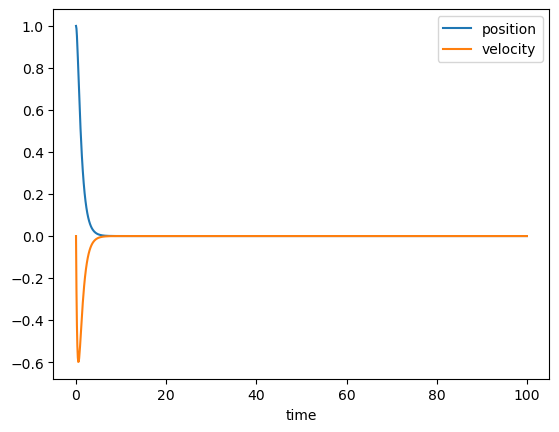

PyObject <matplotlib.legend.Legend object at 0x15106ae60>

In [24]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times,xhist[1,:], label="position")
plot(times,xhist[2,:], label="velocity")
xlabel("time")
legend()

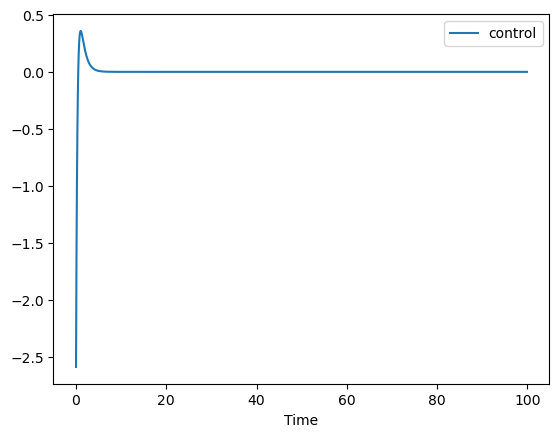

PyObject <matplotlib.legend.Legend object at 0x112771d80>

In [25]:
plot(times[1:end-1], uhist[1,:], label="control")
xlabel("Time")
legend()

In [26]:
J(xhist,uhist)

6.658612220565542

In [27]:
#Forward rollout with random noise
xhist = zeros(n,N)
xhist[:,1] = x0 #10.0*randn(2) #Can start anywhere
uhist = zeros(m,N-1)
for k = 1:(N-1)
    uhist[:,k] .= -K[:,:,k]*xhist[:,k]
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k] + 0.01*randn(2) #can add noise to dynamics
end

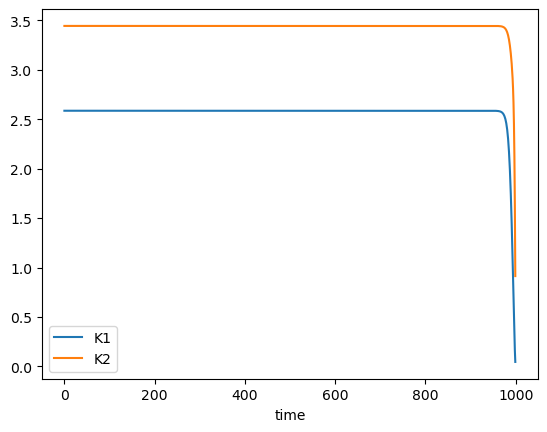

PyObject <matplotlib.legend.Legend object at 0x11280ee30>

In [28]:
plot(K[1,1,:], label="K1")
plot(K[1,2,:], label="K2")
xlabel("time")
legend()

In [29]:
#Compute infinite-horizon K matrix using ControlSystems.jl
Kinf = dlqr(A,B,Q,R)
#Compare to ours
K[:,:,1]-Kinf

1×2 Matrix{Float64}:
 2.53131e-14  1.02141e-14

In [30]:
#Forward rollout with constant K
xhist = zeros(n,N)
xhist[:,1] = x0 #Can start anywhere
uhist = zeros(m,N-1)
for k = 1:(N-1)
    uhist[:,k] .= -Kinf*xhist[:,k]
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k] #+ 0.01*randn(2)
end

In [31]:
#Closed-loop Eigenvalues
eigvals(A-B*Kinf)

2-element Vector{Float64}:
 0.7435575978433924
 0.8991703058887752

In [32]:
function sfloat_integrator_simulation_qp(q_k, v_k; mass = 1, Δt = 0.01)
    
end

sfloat_integrator_simulation_qp (generic function with 1 method)